# Imports

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import pandas as pd
import numpy as np
import os
import ssl
import matplotlib.pyplot as plt

prediction_threshold = 0.3
img_size = 300


In [2]:
# Data Processing v_2.0
import ssl

# --- 0. BASIC SETUP (From Original) ---
ssl._create_default_https_context = ssl._create_unverified_context

def find_project_root(target="slide_images"):
    current = os.getcwd()
    while True:
        if target in os.listdir(current): return current
        parent = os.path.dirname(current)
        if parent == current: break 
        current = parent
    desktop = os.path.expanduser("~/Desktop/Slide Critiques")
    if os.path.exists(os.path.join(desktop, target)): return desktop
    raise FileNotFoundError(f"Cannot find '{target}' folder.")

base_dir = find_project_root()
train_img_dir = os.path.join(base_dir, "slide_images", "training_set")
validation_img_dir  = os.path.join(base_dir, "slide_images", "validation_set")
train_csv_path = os.path.join(base_dir, "slide_images", "training_set_tags.csv")
test_csv_path  = os.path.join(base_dir, "slide_images", "validation_set_tags.csv")

train_df = pd.read_csv(train_csv_path)
validation_df  = pd.read_csv(test_csv_path)
train_df["tags"] = train_df["tags"].apply(lambda x: [t.strip() for t in str(x).split(",") if t.strip()])
validation_df["tags"]  = validation_df["tags"].apply(lambda x: [t.strip() for t in str(x).split(",") if t.strip()])

# =========================================================
# 1. SETUP: Create Base Generator & Calculate Weights First
# =========================================================

# Define the base Keras generator (no cropping yet)
base_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Initialize it to get the class indices
base_generator = base_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_img_dir,
    x_col="filename",
    y_col="tags",
    target_size=(400, 400), # Load larger for cropping
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

# Extract indices immediately
train_indices = base_generator.class_indices

# Define Manual Weights
manual_weights = {
    "Strategic_Text": 3,
    "Data_Chart": 3,         
    "Graphics_Visuals": 3,    
    "Framework_Structure": 2, 
    "Process_Flow": 5,
    "Appendix_Reference": 1,
    "Title_Transition": 1  
}

# Create the Weight Map (Index -> Weight)
class_weights_map = {}
for tag_name, index in train_indices.items():
    class_weights_map[index] = manual_weights.get(tag_name, 1.0)

print(f"Class Weights Map: {class_weights_map}")
# =========================================================
# 2. DEFINE PARALLEL SEQUENCE (With Multi-Scale Logic)
# =========================================================
from tensorflow.keras.preprocessing.image import load_img, img_to_array

class SlideSequence(tf.keras.utils.Sequence):
    def __init__(self, df, directory, x_col, y_col, batch_size, target_size, 
                 class_indices, class_weights_map, shuffle=True):
        self.df = df.copy()
        self.directory = directory
        self.x_col = x_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.target_size = target_size # Likely (300, 300) based on your settings
        self.load_size = (400, 400)    # Load larger to allow room for cropping
        self.class_indices = class_indices
        self.num_classes = len(class_indices)
        self.class_weights_map = class_weights_map
        self.shuffle = shuffle
        
        # Filter out missing files
        self.df['exists'] = self.df[self.x_col].apply(lambda x: os.path.exists(os.path.join(directory, x)))
        self.df = self.df[self.df['exists']].reset_index(drop=True)

        self.y_matrix = self._preprocess_labels()
        self.indexes = np.arange(len(self.df))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def _preprocess_labels(self):
        matrix = np.zeros((len(self.df), self.num_classes), dtype='float32')
        for i, tags in enumerate(self.df[self.y_col]):
            for tag in tags:
                if tag in self.class_indices:
                    matrix[i, self.class_indices[tag]] = 1.0
        return matrix

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_indexes = self.indexes[start:end]
        
        batch_x = []
        batch_sample_weights = []
        batch_y = self.y_matrix[batch_indexes]
        
        for i, idx in enumerate(batch_indexes):
            filename = self.df.iloc[idx][self.x_col]
            img_path = os.path.join(self.directory, filename)
            
            # A. Load Image (Load at 400x400)
            try:
                img = load_img(img_path, target_size=self.load_size)
                img = img_to_array(img) / 255.0
            except:
                img = np.zeros((self.load_size[0], self.load_size[1], 3), dtype='float32')

            # MULTI-SCALE LOGIC 
            if np.random.rand() > 0.5:
                # OPTION 1: CONTEXT VIEW (Resize Whole Slide)
                crop = tf.image.resize(img, self.target_size).numpy()
            
            else:
                # OPTION 2: DETAIL VIEW (Random Crop)
                h, w = img.shape[:2]
                target_h, target_w = self.target_size
                
                if h > target_h and w > target_w:
                    top = np.random.randint(0, h - target_h)
                    left = np.random.randint(0, w - target_w)
                    crop = img[top:top+target_h, left:left+target_w, :]
                else:
                    crop = tf.image.resize(img, self.target_size).numpy()

            batch_x.append(crop)
            
            # C. Sample Weights
            active_indices = np.where(batch_y[i] == 1)[0]
            if len(active_indices) > 0:
                weight = max([self.class_weights_map[k] for k in active_indices])
            else:
                weight = 1.0
            batch_sample_weights.append(weight)
            
        return np.array(batch_x), batch_y, np.array(batch_sample_weights)

# Re-instantiate the dataset
train_dataset = SlideSequence(
    df=train_df,
    directory=train_img_dir,
    x_col="filename",
    y_col="tags",
    batch_size=32,
    target_size=(img_size, img_size), # Passes (300, 300)
    class_indices=train_indices,
    class_weights_map=class_weights_map
)
# Keep labels map generic
labels_map = {v: k for k, v in train_indices.items()}

# =========================================================
# 3. VALIDATION GENERATOR (Standard)
# =========================================================

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    # No smart_resize here, standard resize is faster and consistent for validation
)

validation_dataset = validation_datagen.flow_from_dataframe(
    dataframe=validation_df,
    directory=validation_img_dir,
    x_col="filename",
    y_col="tags",
    class_mode="categorical",
    target_size=(img_size, img_size),
    batch_size=32,
    color_mode="rgb",
    shuffle=False, 
    seed=42
)


Found 285 validated image filenames belonging to 7 classes.
Class Weights Map: {0: 1, 1: 3, 2: 2, 3: 3, 4: 5, 5: 3, 6: 1}
Found 43 validated image filenames belonging to 7 classes.


In [3]:
# Model Creation v_2.0
tf.keras.utils.set_random_seed(42)

# Loading in the Base model as MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(img_size, img_size, 3)
)
base_model.trainable = False

def grayscale_pipe(x):
    gray = tf.image.rgb_to_grayscale(x)
    return tf.image.grayscale_to_rgb(gray)

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomZoom(0.1),
  tf.keras.layers.RandomContrast(0.1),
  tf.keras.layers.Lambda(grayscale_pipe)
])

# Buidling the Mutilabel model
inputs = tf.keras.Input(shape=(img_size, img_size, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalMaxPooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)

num_classes = len(labels_map)
outputs = tf.keras.layers.Dense(num_classes, activation="sigmoid")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')]
)


/var/folders/50/5fmgf98x1372fl24kff2b0j40000gn/T/ipykernel_14098/3691180996.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


In [4]:
# Model Fitting v_2.0

# =========================================================
# 3. TRAINING (Updated model.fit)
# =========================================================

tf.keras.utils.set_random_seed(42)

epochs = 70

# --- 1. Fix the Parallelism (Convert Sequence to tf.data) ---
# Keras 3 removed 'workers' arg. We simulate it by wrapping the sequence 
# into a tf.data.Dataset which handles prefetching automatically.
def sequence_to_tf_dataset(sequence):
    def generator_func():
        for i in range(len(sequence)):
            yield sequence[i]

    # Dynamically get shapes from the first batch
    sample_x, sample_y, sample_w = sequence[0]
    
    output_signature = (
        tf.TensorSpec(shape=sample_x.shape, dtype=tf.float32), # Images
        tf.TensorSpec(shape=sample_y.shape, dtype=tf.float32), # Labels
        tf.TensorSpec(shape=sample_w.shape, dtype=tf.float32)  # Sample Weights
    )

    dataset = tf.data.Dataset.from_generator(
        generator_func, 
        output_signature=output_signature
    )
    
    # The Magic Sauce: Prefetching runs the CPU ahead of the GPU
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# Convert your custom sequence
train_tf_dataset = sequence_to_tf_dataset(train_dataset)

# Redefine callbacks to be safe
class MacroRecall(tf.keras.callbacks.Callback):
    def __init__(self, validation_data, name='val_macro_recall'):
        super().__init__()
        self.validation_data = validation_data
        self.name = name

    def on_epoch_end(self, epoch, logs=None):
        val_gen = self.validation_data
        val_gen.reset()
        y_pred_probs = self.model.predict(val_gen, verbose=0)
        y_pred = (y_pred_probs > prediction_threshold).astype(int) 
        val_gen.reset()
        all_y = []

        steps = len(val_gen)
        for _ in range(steps):
            _, y = next(val_gen)
            all_y.append(y)
        y_true = np.vstack(all_y)
        
        from sklearn.metrics import recall_score
        macro_recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
        logs[self.name] = macro_recall
        print(f" — val_macro_recall: {macro_recall:.4f}")

# checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath='checkpoints/model_epoch_{epoch:02d}.keras', 
#     save_freq='epoch',       # Save after every epoch
#     save_best_only=False,    # Set to False so it saves ALL epochs, not just the "best"
#     verbose=1
# )

macro_callback = MacroRecall(validation_data=validation_dataset)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=epochs/10, min_lr=0.00001)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="best_recall_model.keras", monitor='val_macro_recall', mode='max', save_best_only=True, verbose=1)

# Run Training
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=validation_dataset,
    callbacks=[reduce_lr, 
    macro_callback, 
    checkpoint, 
    # checkpoint_callback
    ]
)
model_history = pd.DataFrame(history.history)
model.save("last_epoch_model.keras")


/Users/noah/Desktop/Slide Critiques/venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.5344 - auc: 0.5045 - loss: 4.7835 - precision: 0.2114 - recall: 0.3981 — val_macro_recall: 0.2916

Epoch 1: val_macro_recall improved from None to 0.29158, saving model to best_recall_model.keras

Epoch 1: saving model to checkpoints/model_epoch_01.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6516 - auc: 0.5749 - loss: 3.5285 - precision: 0.2599 - recall: 0.3396 - val_accuracy: 0.7708 - val_auc: 0.5600 - val_loss: 1.0031 - val_precision: 0.2857 - val_recall: 0.1404 - learning_rate: 0.0010 - val_macro_recall: 0.2916
Epoch 2/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.7414 - auc: 0.6630 - loss: 2.6534 - precision: 0.3642 - recall: 0.2961 — val_macro_recall: 0.4905

Epoch 2: val_macro_recall improved from 0.29158 to 0.49048, saving model to best_recall_model.keras

Epoch 2: saving model to checkpoints/model_epoch_02.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 830ms/step - accuracy: 0.7409 - auc: 0.6839 - loss: 2

In [5]:
model.evaluate(validation_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.8904 - auc: 0.8786 - loss: 0.3313 - precision: 0.7143 - recall: 0.7018


[0.3312537968158722,
 0.8903654217720032,
 0.7142857313156128,
 0.7017543911933899,
 0.8786309957504272]

In [7]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

def plot_training_history(history):
    # Extract data from the history object
    hist = history.history
    
    # Create a figure with 1 row and 4 columns
    fig, axes = plt.subplots(1, 4, figsize=(24, 5))
    
    # Helper to apply grid settings to any axis
    def set_grid(ax):
        # 1. Set Labels (Major Ticks) to appear every 5 epochs
        ax.xaxis.set_major_locator(MultipleLocator(5))
        
        # 2. Set Grid Lines (Minor Ticks) to appear every 1 epoch
        ax.xaxis.set_minor_locator(MultipleLocator(1))
        
        # 3. Turn on the grid for both Major (labels) and Minor (ticks)
        # Major grid (the 5, 10, 15 lines)
        ax.grid(which='major', color='#CCCCCC', linestyle='-')
        # Minor grid (the 1, 2, 3, 4 lines)
        ax.grid(which='minor', color='#CCCCCC', linestyle=':', alpha=0.5)
    
    # 1. Loss vs Val Loss
    axes[0].plot(hist['loss'], label='Train Loss')
    axes[0].plot(hist['val_loss'], label='Val Loss')
    axes[0].set_title('Loss vs. Val Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    set_grid(axes[0]) 

    # 2. Accuracy vs Val Accuracy
    acc_key = 'accuracy' if 'accuracy' in hist else 'acc'
    axes[1].plot(hist[acc_key], label='Train Accuracy')
    axes[1].plot(hist[f'val_{acc_key}'], label='Val Accuracy')
    axes[1].set_title('Accuracy vs. Val Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    set_grid(axes[1])

    # 3. Recall vs Val Recall
    recall_key = 'recall' 
    if recall_key not in hist:
        possible_keys = [k for k in hist.keys() if 'recall' in k and 'val' not in k and 'macro' not in k]
        if possible_keys:
            recall_key = possible_keys[0]
            
    if recall_key in hist:
        axes[2].plot(hist[recall_key], label='Train Recall')
        axes[2].plot(hist[f'val_{recall_key}'], label='Val Recall')
        axes[2].set_title('Recall vs. Val Recall')
        axes[2].set_xlabel('Epochs')
        axes[2].set_ylabel('Recall')
        axes[2].legend()
        set_grid(axes[2])
    else:
        axes[2].set_title('Recall metric not found')
        set_grid(axes[2])

    # 4. Macro Recall
    macro_key = 'val_macro_recall'
    if macro_key in hist:
        axes[3].plot(hist[macro_key], label='Val Macro Recall', color='orange')
        
        train_macro = macro_key.replace('val_', '')
        if train_macro in hist:
            axes[3].plot(hist[train_macro], label='Train Macro Recall', color='blue')
            
        axes[3].set_title('Macro Recall')
        axes[3].set_xlabel('Epochs')
        axes[3].set_ylabel('Score')
        axes[3].legend()
        set_grid(axes[3])
    else:
        axes[3].set_title('Macro Recall metric not found')
        set_grid(axes[3])

    plt.tight_layout()
    plt.show()

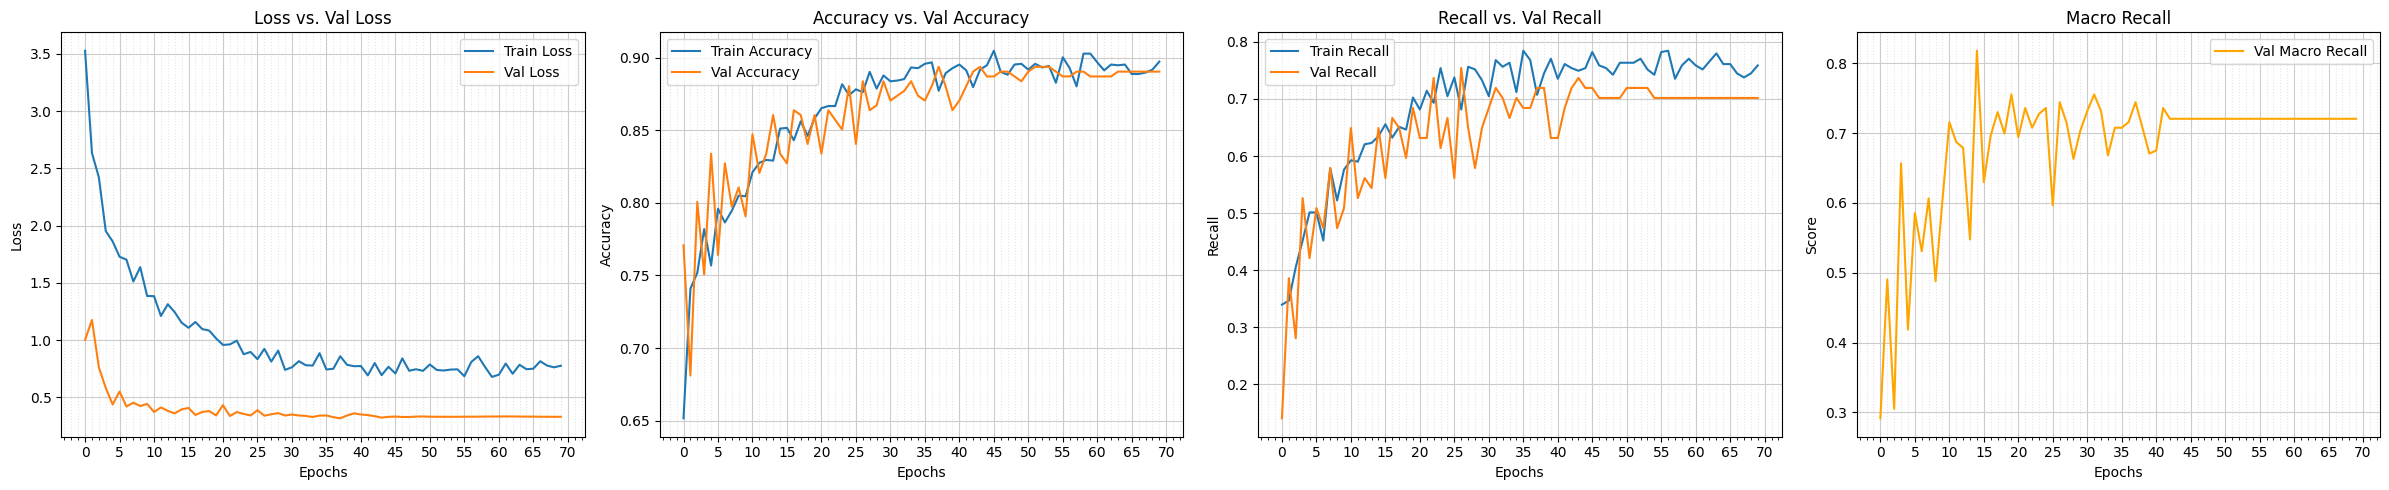

In [8]:
plot_training_history(history)

In [17]:
def grayscale_pipe(x):
    gray = tf.image.rgb_to_grayscale(x)
    return tf.image.grayscale_to_rgb(gray)

best_model = tf.keras.models.load_model(
    "best_recall_model.keras",
    custom_objects={"grayscale_pipe": grayscale_pipe},
    safe_mode=False) 

last_model = tf.keras.models.load_model(
    "last_epoch_model.keras",
    custom_objects={"grayscale_pipe": grayscale_pipe}, # <--- Added this
    safe_mode=False
)

numbered_model = tf.keras.models.load_model(
    "checkpoints/model_epoch_31.keras",
    custom_objects={"grayscale_pipe": grayscale_pipe},
    safe_mode=False
)
best_model.evaluate(validation_dataset)
last_model.evaluate(validation_dataset)
numbered_model.evaluate(validation_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - accuracy: 0.8339 - auc: 0.8533 - loss: 0.3958 - precision: 0.5522 - recall: 0.6491
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 197ms/step - accuracy: 0.8904 - auc: 0.8786 - loss: 0.3313 - precision: 0.7143 - recall: 0.7018
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.8704 - auc: 0.8730 - loss: 0.3509 - precision: 0.6500 - recall: 0.6842


[0.3509080111980438,
 0.8704319596290588,
 0.6499999761581421,
 0.6842105388641357,
 0.8729867935180664]

In [33]:
import numpy as np
import tensorflow as tf
import math

def analyze_thresholds_per_class(model, val_dataset, class_names=None):
    # 1. AUTO-DETECT Total Samples
    # The standard Keras generator stores the exact count in .samples
    if hasattr(val_dataset, 'samples'):
        total_samples = val_dataset.samples
        batch_size = val_dataset.batch_size
        print(f"Detected Keras Generator with {total_samples} images.")
    elif hasattr(val_dataset, 'n'):
        # Older versions of Keras use .n
        total_samples = val_dataset.n
        batch_size = val_dataset.batch_size
        print(f"Detected Keras Generator with {total_samples} images.")
    elif hasattr(val_dataset, 'df'):
        # Case for your custom SlideSequence
        total_samples = len(val_dataset.df)
        batch_size = val_dataset.batch_size
        print(f"Detected Custom Sequence with {total_samples} images.")
    else:
        # Fallback estimate if all else fails
        print("Warning: Could not auto-detect sample count. Using len() estimate.")
        total_samples = len(val_dataset) * 32
        batch_size = 32

    print(f"Starting Evaluation on {total_samples} images...")
    
    # 2. RESET Generator to ensure we start from index 0
    # This prevents the "infinite loop" issue by ensuring we start fresh
    if hasattr(val_dataset, 'reset'):
        val_dataset.reset()
    
    all_y_true = []
    all_y_pred = []
    
    images_processed = 0
    
    # 3. ROBUST LOOP
    # We loop exactly the number of batches required based on exact sample count
    num_batches = int(math.ceil(total_samples / batch_size))
    
    for i in range(num_batches):
        # Fetch batch manually using .next() for generators or indexing for Sequences
        if hasattr(val_dataset, 'next'):
            batch = val_dataset.next()
        else:
            # For Sequences (via __getitem__)
            batch = val_dataset[i]
            
        # Unpack safely (Handle 2 items vs 3 items)
        if len(batch) == 3: x, y, _ = batch # Has weights
        else: x, y = batch # No weights
        
        # Predict on this batch
        preds_batch = model.predict_on_batch(x)
        
        all_y_true.append(y)
        all_y_pred.append(preds_batch)
        
        current_batch_size = x.shape[0]
        images_processed += current_batch_size
        
        if i % 5 == 0:
            print(f" - Processed batch {i+1}/{num_batches} ({images_processed}/{total_samples})...")

    # 4. Stack results
    y_true = np.vstack(all_y_true)
    y_pred_probs = np.vstack(all_y_pred)
    
    # Trim to exact size (removes padding if any occurred in the last batch)
    y_true = y_true[:total_samples]
    y_pred_probs = y_pred_probs[:total_samples]

    num_classes = y_true.shape[1]
    
    # Auto-detect class names from generator if not provided
    if class_names is None and hasattr(val_dataset, 'class_indices'):
        # Invert the dictionary: {0: 'Appendix', 1: 'Chart'} -> List of names
        idx_to_class = {v: k for k, v in val_dataset.class_indices.items()}
        class_names = [idx_to_class[i] for i in range(num_classes)]
    elif class_names is None:
        class_names = [f"Class_{i}" for i in range(num_classes)]
    
    # --- ANALYSIS LOOP ---
    thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    
    for thresh in thresholds:
        print(f"\n{'='*20} THRESHOLD: {thresh} {'='*20}")
        y_pred_filtered = (y_pred_probs > thresh).astype(int)
        
        print(f"{'Category':<20} | {'Prec':<6} | {'Rec':<6} | {'F1':<6} || {'Correct':<8} | {'Missed':<8} | {'Hallucinated':<12}")
        print("-" * 95)
        
        for i, name in enumerate(class_names):
            true_col = y_true[:, i]
            pred_col = y_pred_filtered[:, i]
            
            # Calculate True Positives, False Negatives, False Positives
            tp = np.sum((true_col == 1) & (pred_col == 1))
            fn = np.sum((true_col == 1) & (pred_col == 0))
            fp = np.sum((true_col == 0) & (pred_col == 1))
            
            prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
            rec  = tp / (tp + fn) if (tp + fn) > 0 else 0.0
            f1   = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0.0
            
            print(f"{name:<20} | {prec:.2f}   | {rec:.2f}   | {f1:.2f}   || {tp:<8} | {fn:<8} | {fp:<12}")

# --- RUN IT ---
# No need to manually calculate totals anymore.
analyze_thresholds_per_class(numbered_model, validation_dataset)


Detected Keras Generator with 43 images.
Starting Evaluation on 43 images...
 - Processed batch 1/2 (32/43)...

==================== THRESHOLD: 0.3 ====================
Category             | Prec   | Rec    | F1     || Correct  | Missed   | Hallucinated
-----------------------------------------------------------------------------------------------
Appendix_Reference   | 1.00   | 0.94   | 0.97   || 16       | 1        | 0           
Data_Chart           | 0.33   | 0.50   | 0.40   || 1        | 1        | 2           
Framework_Structure  | 0.39   | 0.90   | 0.55   || 9        | 1        | 14          
Graphics_Visuals     | 0.50   | 0.60   | 0.55   || 3        | 2        | 3           
Process_Flow         | 0.40   | 0.33   | 0.36   || 2        | 4        | 3           
Strategic_Text       | 0.42   | 0.85   | 0.56   || 11       | 2        | 15          
Title_Transition     | 0.80   | 1.00   | 0.89   || 4        | 0        | 1           

==================== THRESHOLD: 0.4 ==========

Found 43 validated image filenames belonging to 7 classes.
Generating predictions...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step
Extracting true labels...


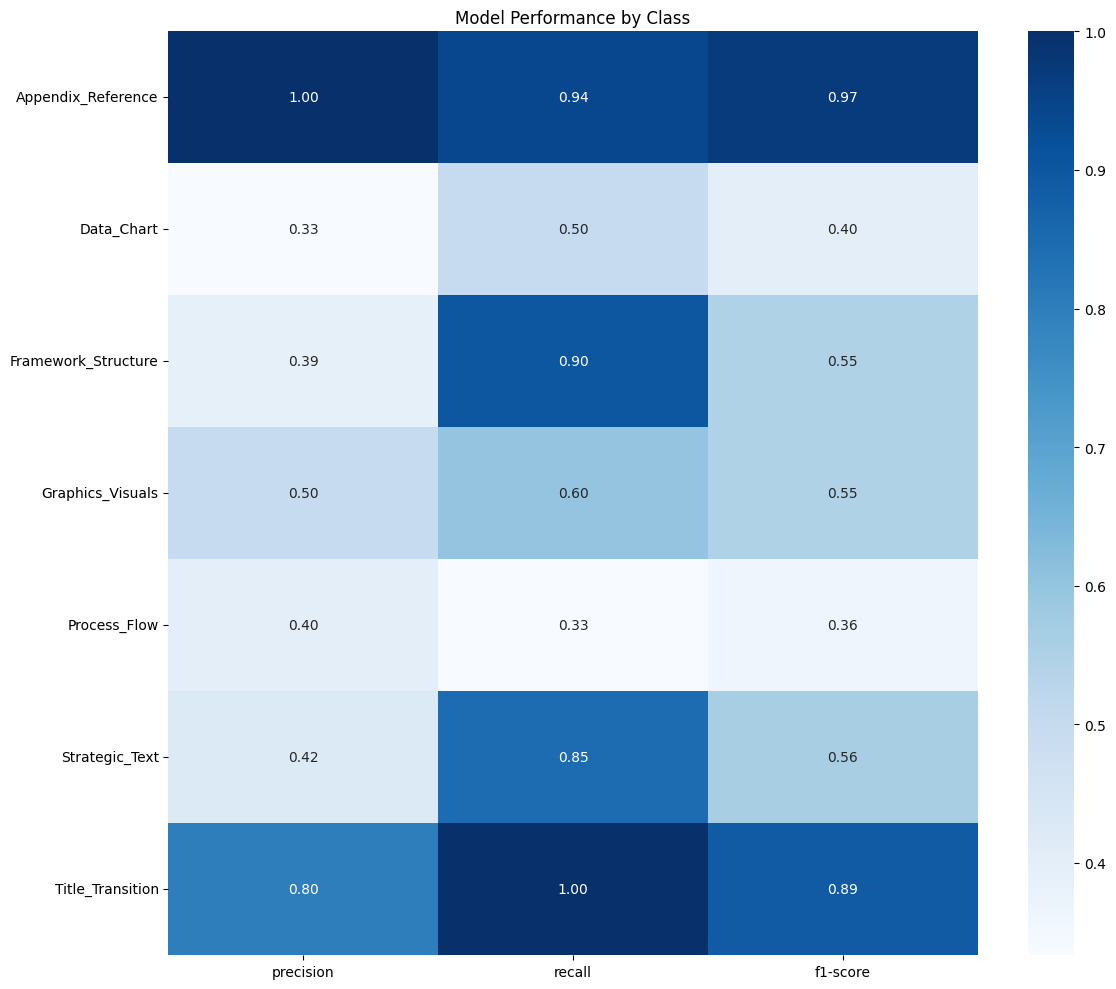

In [34]:
selected_model = numbered_model

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report


# 1. Re-create validation generator without shuffle
# CRITICAL FIX: Changed grayscale to rgb
eval_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

eval_dataset = eval_datagen.flow_from_dataframe(
    dataframe=validation_df,                 # Make sure this is your 'df' from the training script
    directory = validation_img_dir,
    x_col="filename",
    y_col="tags",
    class_mode="categorical",
    target_size=(img_size, img_size),       # Ensure this matches your model input
    batch_size=32,
    color_mode="rgb",             # <--- FIXED (MobileNet needs RGB)
    shuffle=False,                # <--- CRITICAL for evaluation
    seed=42
)

# 2. Get Predictions
print("Generating predictions...")
y_pred_probs = selected_model.predict(eval_dataset)
y_pred = (y_pred_probs > prediction_threshold).astype(int)

# 3. Get True Labels
print("Extracting true labels...")
y_true = []
for i in range(len(eval_dataset)):
    _, batch_y = eval_dataset[i]
    y_true.append(batch_y)
y_true = np.vstack(y_true)

# 4. Generate Classification Report
# Ensure labels_map is {0: 'TagA', 1: 'TagB'}
ordered_class_names = [labels_map[i] for i in range(len(labels_map))]

report_dict = classification_report(
    y_true, 
    y_pred, 
    target_names=ordered_class_names, 
    output_dict=True, 
    zero_division=0
)

# 5. Visualize
report_df = pd.DataFrame(report_dict).transpose()

# Filter out the support/avg rows to focus on classes
plot_df = report_df.drop(['micro avg', 'macro avg', 'weighted avg', 'samples avg'], errors='ignore')

plt.figure(figsize=(12, 10)) # Adjusted size
sns.heatmap(plot_df[['precision', 'recall', 'f1-score']], annot=True, cmap="Blues", fmt=".2f")
plt.title("Model Performance by Class")
plt.tight_layout()
plt.show()

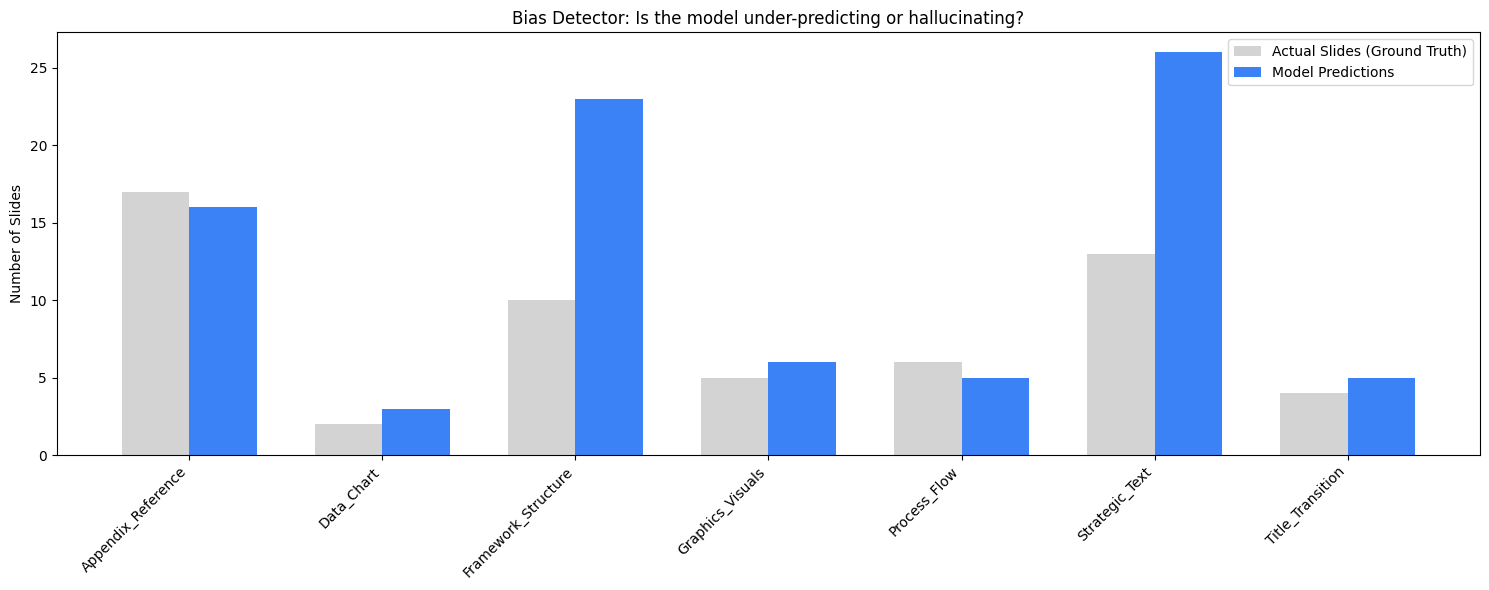

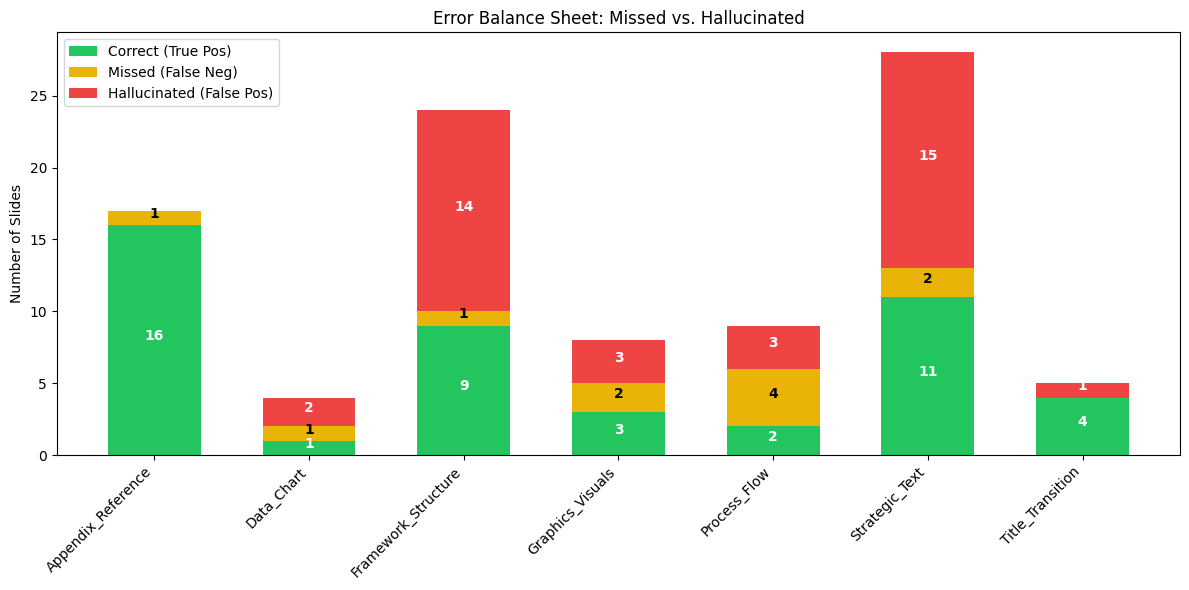

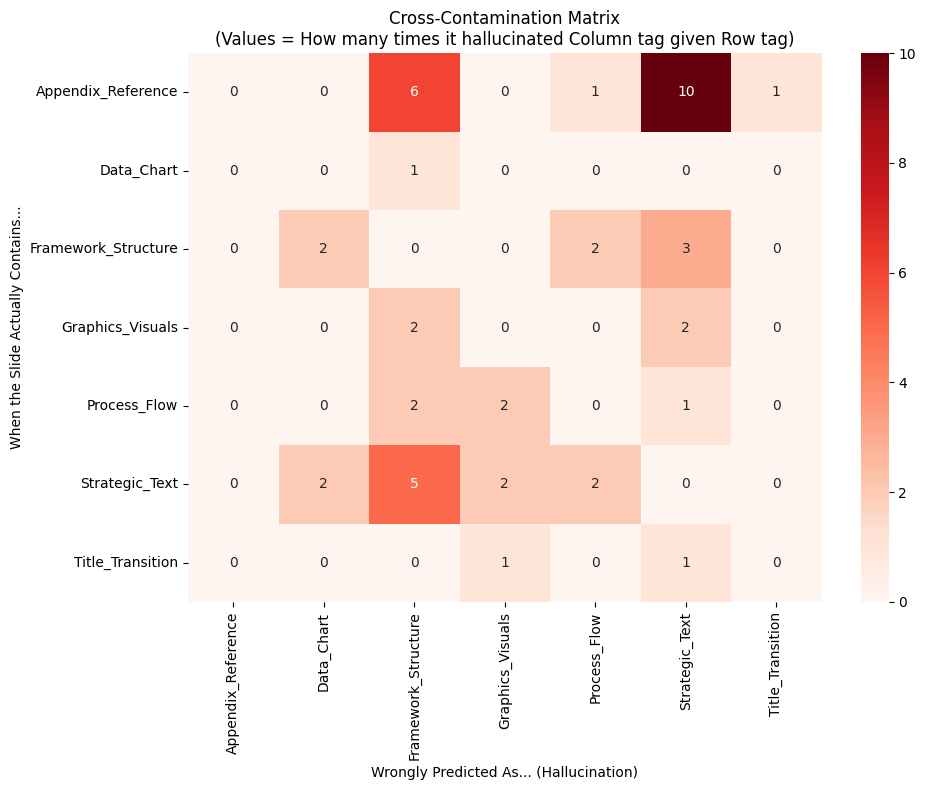

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# ==========================================
# 1. THE BIAS DETECTOR (Quantitative)
# Checks if the model is ignoring certain classes
# ==========================================
def plot_bias_detector(y_true, y_pred, class_names):
    # Sum up the columns to get total counts per tag
    true_counts = y_true.sum(axis=0)
    pred_counts = y_pred.sum(axis=0)

    x = np.arange(len(class_names))
    width = 0.35

    plt.figure(figsize=(15, 6))
    
    # Plot Ground Truth (Gray) vs Predictions (Blue)
    plt.bar(x - width/2, true_counts, width, label='Actual Slides (Ground Truth)', color='lightgray')
    plt.bar(x + width/2, pred_counts, width, label='Model Predictions', color='#3b82f6')

    plt.ylabel('Number of Slides')
    plt.title('Bias Detector: Is the model under-predicting or hallucinating?')
    plt.xticks(x, class_names, rotation=45, ha="right")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Run Bias Detector using the variables already in your notebook
plot_bias_detector(y_true, y_pred, ordered_class_names)

def plot_error_balance(y_true, y_pred, class_names):
    # Calculate True Positives, False Positives, False Negatives per class
    # Axis 0 = Summing down the rows (aggregating all images)
    tp = np.sum((y_true == 1) & (y_pred == 1), axis=0) # Correct
    fn = np.sum((y_true == 1) & (y_pred == 0), axis=0) # Missed (Yellow)
    fp = np.sum((y_true == 0) & (y_pred == 1), axis=0) # Hallucinated (Red)

    x = np.arange(len(class_names))
    width = 0.6

    plt.figure(figsize=(12, 6))
    
    # Stacked Bars
    p1 = plt.bar(x, tp, width, color='#22c55e', label='Correct (True Pos)')
    p2 = plt.bar(x, fn, width, bottom=tp, color='#eab308', label='Missed (False Neg)')
    p3 = plt.bar(x, fp, width, bottom=tp+fn, color='#ef4444', label='Hallucinated (False Pos)')

    plt.ylabel('Number of Slides')
    plt.title('Error Balance Sheet: Missed vs. Hallucinated')
    plt.xticks(x, class_names, rotation=45, ha="right")
    plt.legend()
    
    # Add numbers inside bars
    for i in range(len(class_names)):
        # TP Label
        if tp[i] > 0: plt.text(i, tp[i]/2, str(int(tp[i])), ha='center', color='white', fontweight='bold')
        # FN Label
        if fn[i] > 0: plt.text(i, tp[i] + fn[i]/2, str(int(fn[i])), ha='center', color='black', fontweight='bold')
        # FP Label
        if fp[i] > 0: plt.text(i, tp[i] + fn[i] + fp[i]/2, str(int(fp[i])), ha='center', color='white', fontweight='bold')

    plt.tight_layout()
    plt.show()

# ==========================================
# 2. THE CROSS-CONTAMINATION MATRIX (Heatmap)
# Best for: "When it's actually Text, does it think it's a Graphic?"
# ==========================================
def plot_confusion_heatmap(y_true, y_pred, class_names):
    # Create a matrix M where M[i, j] = Count where True is i AND Pred is j
    # But we ONLY care about ERRORS (where i != j)
    # Since it's multi-label, we look for: True Label i exists, Pred Label j exists, but True Label j does NOT exist.
    
    num_classes = len(class_names)
    matrix = np.zeros((num_classes, num_classes))

    for i in range(num_classes):      # The True Label
        for j in range(num_classes):  # The Predicted Label
            if i == j: 
                continue # Skip diagonal (Correct predictions)
            
            # Condition: Slide has True[i], Model Predicted[j], but Slide does NOT have True[j]
            # This counts "Hallucinating J when I was supposed to see I"
            mask = (y_true[:, i] == 1) & (y_pred[:, j] == 1) & (y_true[:, j] == 0)
            matrix[i, j] = np.sum(mask)

    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, cmap="Reds", xticklabels=class_names, yticklabels=class_names, fmt='g')
    
    plt.xlabel("Wrongly Predicted As... (Hallucination)")
    plt.ylabel("When the Slide Actually Contains...")
    plt.title("Cross-Contamination Matrix\n(Values = How many times it hallucinated Column tag given Row tag)")
    plt.tight_layout()
    plt.show()

# Run them
plot_error_balance(y_true, y_pred, ordered_class_names)
plot_confusion_heatmap(y_true, y_pred, ordered_class_names)

Found 43 validated image filenames belonging to 7 classes.
Generating raw probabilities...

--- Applying Custom Thresholds ---
   Appendix_Reference  : 0.3
   Data_Chart          : 0.2
   Framework_Structure : 0.6
   Graphics_Visuals    : 0.4
   Process_Flow        : 0.25
   Strategic_Text      : 0.5
   Title_Transition    : 0.8

Classification Report:
                     precision    recall  f1-score   support

 Appendix_Reference       1.00      0.94      0.97        17
         Data_Chart       0.20      0.50      0.29         2
Framework_Structure       0.60      0.90      0.72        10
   Graphics_Visuals       0.60      0.60      0.60         5
       Process_Flow       0.25      0.33      0.29         6
     Strategic_Text       0.53      0.77      0.62        13
   Title_Transition       1.00      1.00      1.00         4

          micro avg       0.62      0.79      0.70        57
          macro avg       0.60      0.72      0.64        57
       weighted avg       0.68   

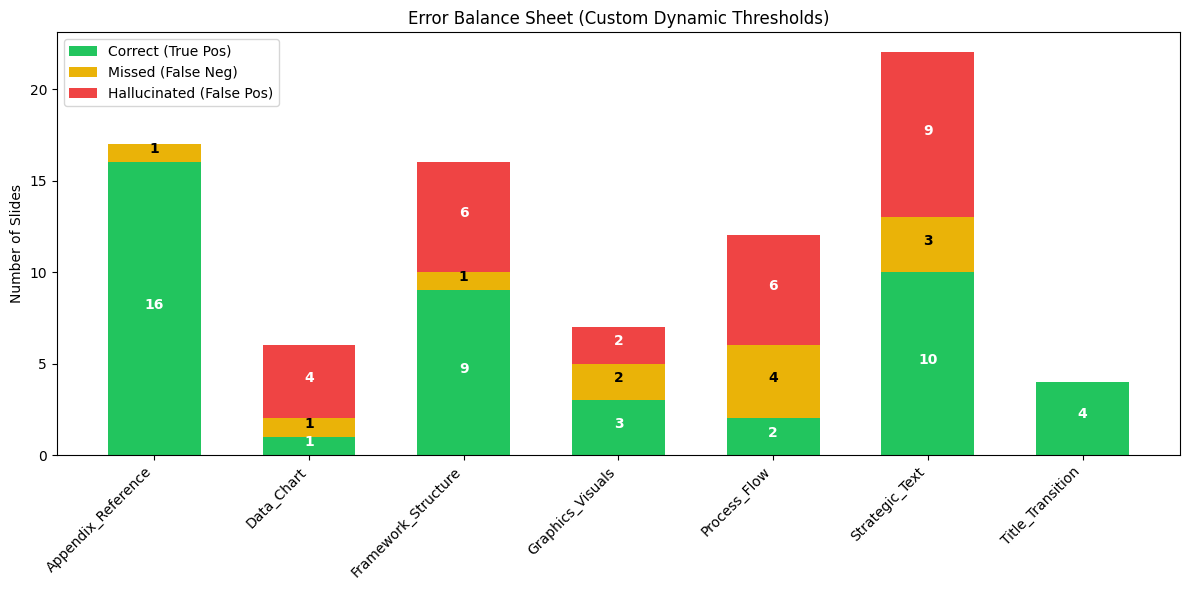

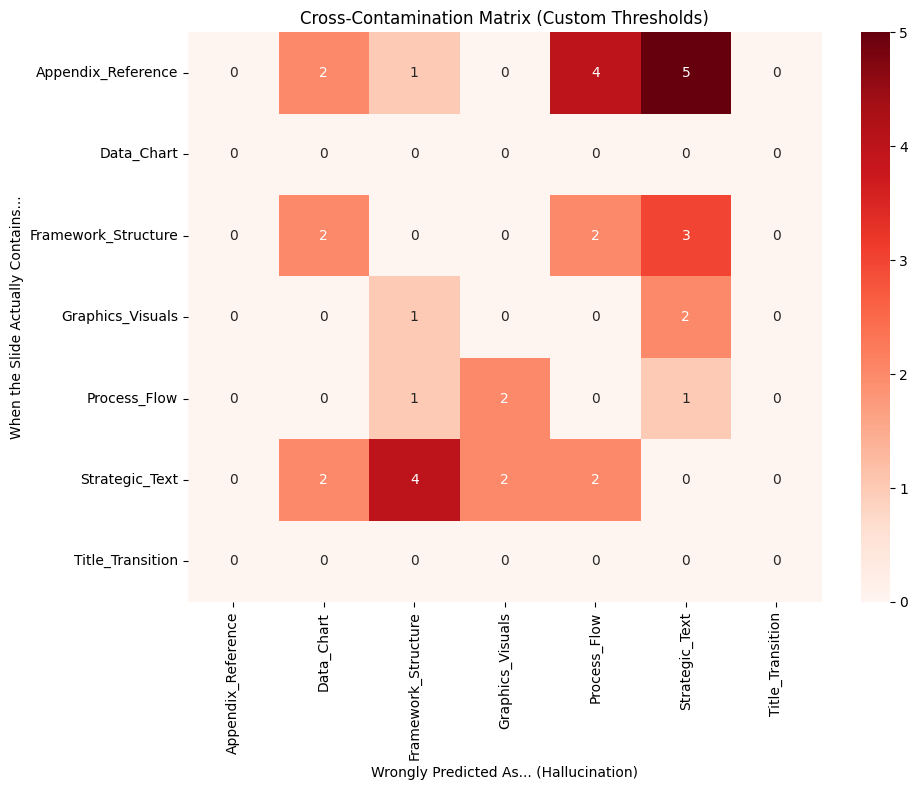

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report
import math

# ==========================================
# 1. CONFIGURATION: PER-CLASS THRESHOLDS
# ==========================================
# Adjust these values based on your analysis
# THRESHOLD_MAP = {
#     'Appendix_Reference':  0.3,
#     'Data_Chart':          0.3, 
#     'Framework_Structure': 0.7,  
#     'Graphics_Visuals':    0.4,
#     'Process_Flow':        0.25,  
#     'Strategic_Text':      0.5,  
#     'Title_Transition':    0.5
# }

THRESHOLD_MAP = {
    'Appendix_Reference':  0.3,
    'Data_Chart':          0.2, 
    'Framework_Structure': 0.6,  
    'Graphics_Visuals':    0.4,
    'Process_Flow':        0.25,  
    'Strategic_Text':      0.5,  
    'Title_Transition':    0.8
}


selected_model = numbered_model

# ==========================================
# 2. PLOTTING FUNCTIONS
# ==========================================
def plot_error_balance(y_true, y_pred, class_names):
    tp = np.sum((y_true == 1) & (y_pred == 1), axis=0)
    fn = np.sum((y_true == 1) & (y_pred == 0), axis=0)
    fp = np.sum((y_true == 0) & (y_pred == 1), axis=0)

    x = np.arange(len(class_names))
    width = 0.6

    plt.figure(figsize=(12, 6))
    p1 = plt.bar(x, tp, width, color='#22c55e', label='Correct (True Pos)')
    p2 = plt.bar(x, fn, width, bottom=tp, color='#eab308', label='Missed (False Neg)')
    p3 = plt.bar(x, fp, width, bottom=tp+fn, color='#ef4444', label='Hallucinated (False Pos)')

    plt.ylabel('Number of Slides')
    plt.title('Error Balance Sheet (Custom Dynamic Thresholds)')
    plt.xticks(x, class_names, rotation=45, ha="right")
    plt.legend()
    
    for i in range(len(class_names)):
        if tp[i] > 0: plt.text(i, tp[i]/2, str(int(tp[i])), ha='center', color='white', fontweight='bold')
        if fn[i] > 0: plt.text(i, tp[i] + fn[i]/2, str(int(fn[i])), ha='center', color='black', fontweight='bold')
        if fp[i] > 0: plt.text(i, tp[i] + fn[i] + fp[i]/2, str(int(fp[i])), ha='center', color='white', fontweight='bold')

    plt.tight_layout()
    plt.show()

def plot_confusion_heatmap(y_true, y_pred, class_names):
    num_classes = len(class_names)
    matrix = np.zeros((num_classes, num_classes))

    for i in range(num_classes):      
        for j in range(num_classes):  
            if i == j: continue 
            mask = (y_true[:, i] == 1) & (y_pred[:, j] == 1) & (y_true[:, j] == 0)
            matrix[i, j] = np.sum(mask)

    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, cmap="Reds", xticklabels=class_names, yticklabels=class_names, fmt='g')
    plt.xlabel("Wrongly Predicted As... (Hallucination)")
    plt.ylabel("When the Slide Actually Contains...")
    plt.title("Cross-Contamination Matrix (Custom Thresholds)")
    plt.tight_layout()
    plt.show()

# ==========================================
# 3. DATA GENERATION (Run Once)
# ==========================================
# Re-create Generator
eval_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
eval_dataset = eval_datagen.flow_from_dataframe(
    dataframe=validation_df,
    directory=validation_img_dir,
    x_col="filename",
    y_col="tags",
    class_mode="categorical",
    target_size=(img_size, img_size),
    batch_size=32,
    color_mode="rgb",
    shuffle=False, 
    seed=42
)

# Extract Class Names
class_indices = eval_dataset.class_indices
class_names = list(dict(sorted(class_indices.items(), key=lambda item: item[1])).keys())

# Always generate new predictions
print("Generating raw probabilities...")
eval_dataset.reset()
y_true_list, y_pred_list = [], []
num_batches = int(math.ceil(eval_dataset.samples / eval_dataset.batch_size))

for i in range(num_batches):
    batch = next(eval_dataset)
    if len(batch) == 3: 
        x, y, _ = batch
    else: 
        x, y = batch
    y_true_list.append(y)
    y_pred_list.append(selected_model.predict_on_batch(x))

# Aggregate and truncate to exact sample count
y_true = np.vstack(y_true_list)[:eval_dataset.samples]
y_pred_probs = np.vstack(y_pred_list)[:eval_dataset.samples]

# ==========================================
# 4. APPLY DYNAMIC THRESHOLDS
# ==========================================
print("\n--- Applying Custom Thresholds ---")
for k, v in THRESHOLD_MAP.items():
    print(f"   {k:<20}: {v}")

# Create an array of thresholds in the same order as class_names
threshold_vector = np.array([THRESHOLD_MAP.get(name, 0.5) for name in class_names])

# Broadcast comparison: Each column compares against its own threshold
y_pred_dynamic = (y_pred_probs > threshold_vector).astype(int)

# 1. Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_dynamic, target_names=class_names, zero_division=0))

# 2. Plots
plot_error_balance(y_true, y_pred_dynamic, class_names)
plot_confusion_heatmap(y_true, y_pred_dynamic, class_names)

In [38]:
def grayscale_pipe(x):
    gray = tf.image.rgb_to_grayscale(x)
    return tf.image.grayscale_to_rgb(gray)

production_model = tf.keras.models.load_model(
    "multilabeling_model.keras",
    custom_objects={"grayscale_pipe": grayscale_pipe},
    safe_mode=False) 

production_model.save("multilabeling_model.h5")

TypeError: cannot pickle 'module' object